<a href="https://colab.research.google.com/github/mdominguezd/PyTorch_Training/blob/main/U_Net_Implementation_Based_DL_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic segmentation using CNNs on remote sensing images

## 1) Copy the data to your Drive
The first thing we need to do is to get access to the data.

For this, you are going to copy the Vaihingen dataset in your own Google drive. Access the folder [here](https://drive.google.com/drive/folders/1Tr3q8kjPDzoamNFuHv7vTBsj5-acJC7Z?usp=sharing) and copy it or create a shortcut to "My Drive".

Once this is done, you need to mount your drive in this notebook. This is done by executing the following two lines. You will need to authorize google colab to access your drive (just follow the instructions that will show up).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We should now have access to our data in google drive, check it by running this command. It should the folders containing the data. Depending on where you saved the folder, you might have to change the path if you see a `"No such file or directory"` error. Within the DataVaihingen folder, we will only use the RGB images stored in `DataVaihingen/top` and the ground truth maps in `DataVaihingen/1CGT`.

In [ ]:
!ls "/content/drive/My Drive/Workshop_Semantic_Segmentation/"

ls: cannot access '/content/drive/My Drive/Workshop_Semantic_Segmentation/': No such file or directory


To make things a bit cleaner, let's save this base directory. Make sure that you use the same directory as above!

In [ ]:
base_folder = '/content/drive/My Drive/Workshop_Semantic_Segmentation'

## 2) Preparing the dataset for Pytorch
### 2.1) Taking a look at the data
Now that we have access to the data, let's do something with it!

What we want to do is called *semantic segmentation*. In short, we want to give a class to each pixel of the input image. Let's start by taking a look at ones of the images and the corresponding Ground Truth (GT) map of labels:

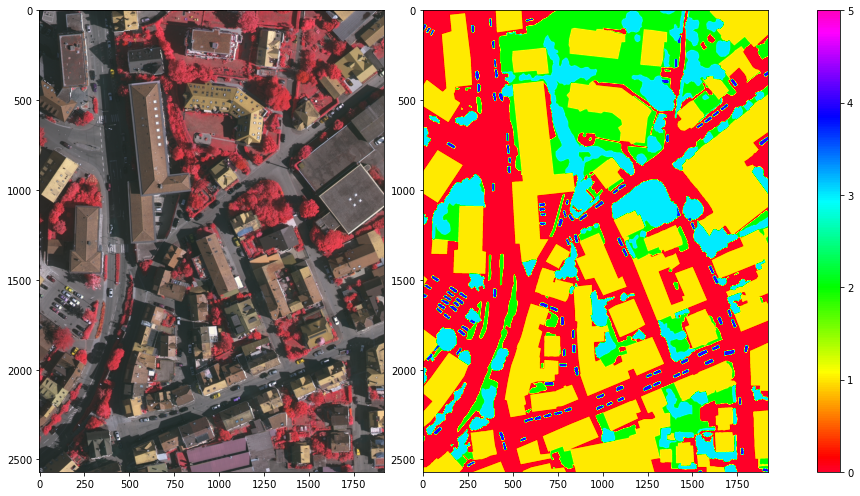

In [ ]:
import skimage.io as io
import matplotlib.pyplot as plt
import os

image_id = 1
image_name = 'top_mosaic_09cm_area' + str(image_id) + '.tif'
image_path = os.path.join(base_folder, 'DataVaihingen/top/', image_name)
image = io.imread(image_path)
GT_path = os.path.join(base_folder, 'DataVaihingen/1CGT/', image_name)
GT = io.imread(GT_path)
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(14,7)
axs[0].imshow(image)
map = axs[1].imshow(GT,cmap=plt.get_cmap('gist_rainbow'),vmin=0,vmax=5)
fig.tight_layout()
fig.colorbar(map,ax=axs[:])

We just printed one image and its ground truth (i.e. what we would like to be able to estimate).

If you go to the [website of the dataset](https://www.isprs.org/education/benchmarks/UrbanSemLab/semantic-labeling.aspx), you can get the legend:
0. Impervious surface (road, side walk, etc)
1. Building
2. Low vegetation
3. Tree
4. Car
5. Clutter/background

So in short, we want to approximate a function which takes an image as input (more specifically *near, red, green* images) and return an image of the same spatial size where each pixel can have one of the 6 values defined above.

### 2.2) Loading the data

The next step is to prepare the data to be used by a CNN. The images are quite large (over 2000 pixels per side), which could lead to GPU memory issues.

In our case, we crop our images to patches of regular size ($512\times 512$) and transform the image so that pytorch understands it (change the data from a numpy array to a tensor and shift the values to the $[0,1]$ range).

We also need to divide the dataset in the train/validation/test sets. The official split is, in terms of image ID:
* Train: $[1,3,5,7,11,13,15,17,21,23,26,28,30,32,34,37]$
* Test: $[2,4,6,8,10,12,14,16,20,22,24,27,29,31,33,35,38]$

However, in order to make training faster we will only be using three images for training and two for validation.

The following piece of code does all the data reading and pre-processing for you and stores all the ($512\times 512$) image patches in a list called `imgs` and all the ground truth patches in a list called `GTs`. Take a look to see how it does that.

In [ ]:
import os
from skimage import io
import numpy as np
import torch
import torchvision.transforms as T


image_ids = [1,3,5]
img_folder = os.path.join(base_folder, 'DataVaihingen/top/')
GT_folder = os.path.join(base_folder, 'DataVaihingen/1CGT/')
split = 'train' # Can be 'train', 'val' or 'test'
patch_size=512

imgs = []
GTs = []

#This will convert the numpy array to a tensor
conversion = T.ToTensor()
#Amount of overlap when defining the patches. If your dataset is big enough,
#you might not need to have overlaps
overlap = patch_size // 2

for img_index in image_ids:
  print("Working on image " + str(img_index))
  #Load the tile and the corresponding ground truth.
  img = io.imread(os.path.join(img_folder, "top_mosaic_09cm_area" + str(img_index) + '.tif')).astype(np.float32)/255
  GT = io.imread(os.path.join(GT_folder, "top_mosaic_09cm_area" + str(img_index) + '.tif')).astype(np.float32)

  #Crop into patches, following a regularly sampled grid.
  #i and j are defined as the center of the patch to crop.
  for i in np.arange(patch_size//2, img.shape[0] - patch_size // 2, overlap):
    for j in np.arange(patch_size//2, img.shape[1] - patch_size // 2, overlap):
      #Crop the image and the ground truth into patch around (i,j) and save
      #them in self.imgs and self.GTs arrays.
      #For the image, note that we are taking the three channels (using ":")
      #for the 3rd dimension, and we do the conversion to tensor.
      im_patch = img[i - patch_size//2:i + patch_size // 2, j - patch_size // 2:j + patch_size // 2,:]
      imgs.append(conversion(im_patch))
      GT_patch = GT[i - patch_size//2:i + patch_size // 2, j - patch_size // 2:j + patch_size // 2]
      GT_patch = conversion(GT_patch)
      GTs.append(GT_patch)

Working on image 1
Working on image 3
Working on image 5


Let's take a look at the data containers we created (`imgs`, `GTs`), by looking at the variable inspector. See $\{x\}$ in the left panel

Alteratively we can print some statistics:
* Check the number of image patches in each by typing `print(len(imgs))`.
* Check the size of one of the elements in each list. For example, `print(imgs[9].shape)`.

To do this, create one or more code cells here by clicking on the +Code button above or on Insert/Code cell.

Let's also visualize one pair.

Note the [`Tensor.permute()`](https://pytorch.org/docs/stable/generated/torch.permute.html#torch.permute) operation on the image patch, which is meant to transform the patch from a shape of $[3,512,512]$ to $[512,512,3]$, and the `[0,:,:]` (you could also use [`Tensor.squeeze()`](https://pytorch.org/docs/stable/generated/torch.squeeze.html#torch.squeeze)) which removes the first dimension and turns the $[1,512,512]$ GT patch into $[512,512]$. These operations are required to plot the images. Discuss the reasons for this with your classmates.

Try with different values for `sample_id`.

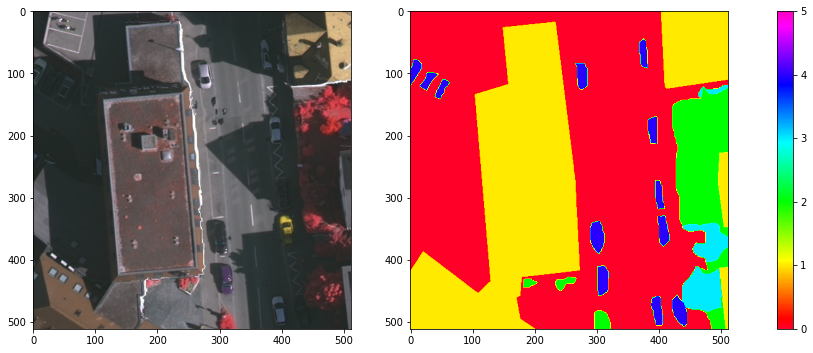

In [ ]:
sample_id = 0
image = imgs[sample_id].permute(1,2,0)
GT = GTs[sample_id][0,:,:]
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(14,5)
axs[0].imshow(image)
map = axs[1].imshow(GT,cmap=plt.get_cmap('gist_rainbow'),vmin=0,vmax=5)
fig.tight_layout()
fig.colorbar(map,ax=axs[:])

### 2.3) Building a Pytorch dataset class

This is nice, but in order to make this more usable with Pytorch, it is better to put this inside a custom dataset class.

In the following code cell, you can see the structure of the Pytorch Dataset class.

First, we define a class with the name of our choice (`VaihingenDataset` seems like a reasonable one). We make sure that it inherits all the properties of the Dataset super-class by importing it and declaring:
`class VaihingenDataset(Dataset):`

Now, we need to override three methods (a method is a function defined within a class):
* `__init__(self,init_arguments):` as all methods, the first argument it receives is the dataset object itself. This method has to contain all the information required to read and pre-process the data. Use the code from the previous cell (Section 2.2) here. Just make sure that you convert `imgs` into `self.imgs`, and `GTs` into `self.GTs`. This way the images and labels will be stored within the dataset object for future use.
* `__len__(self):` this simply returns the number of elements in the dataset.
* `__getitem__(self,idx):` given and index `idx`, this method returns the sample number `idx`. In this case, that is one image patch and the corresponding ground truth patch.


In [ ]:
%%script echo skipping
### CODING SECTION 2.3

from torch.utils.data import Dataset

class VaihingenDataset(Dataset):
  def __init__(self, img_folder, GT_folder, image_ids, patch_size=512):
    '''This is the method to initialize the dataset. It needs to know where to find
    the data, how to read it and pre-process it.
    Arguments:
      img_folder: the path to the images
      GT_folder: the path to the GT maps
      image_ids: the ids of the images to read
      patch_size: the side of the resulting square patches'''

    ### ADD HERE THE CODE FROM THE PREVIOUS CELL
    # make sure to convert imgs into self.imgs and GTs into self.GTs
    #####################

  def __len__(self):
    # This simply returns the total number of samples
    return len(self.imgs)

  def __getitem__(self, idx):
    #__getitem__ asks for the sample number idx and returns one sample, the one
    # with that id. In our case we need one image patch and the corresponding
    # ground truth.
    img = self.imgs[idx].float()
    GT = self.GTs[idx]

    return img, GT

skipping


In [ ]:
### SOLUTION CODING SECTION 2.3

import os
from skimage import io
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T



class VaihingenDataset(Dataset):
  def __init__(self, img_folder, GT_folder, image_ids, patch_size=512):
    self.imgs = []
    self.GTs = []

    #This will convert the numpy array to a tensor
    conversion = T.ToTensor()
    #Amount of overlap when defining the patches. If your dataset is big enough,
    #you might not need to have overlaps
    overlap = patch_size // 2

    for img_index in image_ids:
      print("Working on image " + str(img_index))
      #Load the tile and the corresponding ground truth.
      img = io.imread(os.path.join(img_folder, "top_mosaic_09cm_area" + str(img_index) + '.tif')).astype(np.float32)/255
      GT = io.imread(os.path.join(GT_folder, "top_mosaic_09cm_area" + str(img_index) + '.tif')).astype(np.float32)

      #Crop into patches, following a regularly sampled grid.
      #i and j are defined as the center of the patch to crop.
      for i in np.arange(patch_size//2, img.shape[0] - patch_size // 2, overlap):
        for j in np.arange(patch_size//2, img.shape[1] - patch_size // 2, overlap):
          #Crop the image and the ground truth into patch around (i,j) and save
          #them in self.imgs and self.GTs arrays.
          #For the image, note that we are taking the three channels (using ":")
          #for the 3rd dimension, and we do the conversion to tensor.
          im_patch = img[i - patch_size//2:i + patch_size // 2, j - patch_size // 2:j + patch_size // 2,:]
          self.imgs.append(conversion(im_patch))
          GT_patch = GT[i - patch_size//2:i + patch_size // 2, j - patch_size // 2:j + patch_size // 2]
          GT_patch = conversion(GT_patch)
          self.GTs.append(GT_patch)

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    #__getitem__ asks for the sample number idx. Since we pre-loaded the images
    #and the ground truths, we just have to return the corresponding sample.
    img = self.imgs[idx].float()
    GT = self.GTs[idx]

    #We also need to return the ground truth as a tensor
    return img, GT

One we have a dataset class, we can use it in a so-called dataloader. This is a class which will help us to load the data in batches (to speed-up computation).

A batch is a list of inputs that will be fed to the network at once (making use of the ability of our machines to do parallel operations). To select these samples, there are several sampling strategies which can be used (mostly sequential and random). Both of these strategies are already implemented in pytorch:

In [ ]:
#The batch size should generally be as big as your machine can take it.
batch_size = 3
#Define the data splits. Here, we take just a few images for fast training.
image_ids_train = [1,3,5]
image_ids_val = [26,28]
training_dataset = VaihingenDataset(os.path.join(base_folder, 'DataVaihingen/top/'), os.path.join(base_folder, 'DataVaihingen/1CGT/'), image_ids_train)
validate_dataset = VaihingenDataset(os.path.join(base_folder, 'DataVaihingen/top/'), os.path.join(base_folder, 'DataVaihingen/1CGT/'), image_ids_val)

Working on image 1
Working on image 3
Working on image 5
Working on image 26
Working on image 28


Now, `imgs` and `GTs`, as we saw them before, are wrapped in the dataset objects `training_dataset` and `validate_dataset`. They can be retrieved by simply typing, for example, `training_dataset.imgs`.

In addition, the `getitem` method can also be used to retrieve an image/GT pair.

These dataset objects can directly be transformed into a Pytorch object called `DataLoader`. The `DataLoader` takes charge of building the batches for training a CNN by randomly shuffling the samples and collating them into a batch.

In [ ]:
#Note that we shuffle the data for the training set, but not for the validation set:
train_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
validate_loader = torch.utils.data.DataLoader(dataset=validate_dataset, batch_size=batch_size, shuffle=False)

### 2.4) Check that the data is correcly loaded
You already know how the images should look like. Visualize the images in a batch to verify that the dataset dataloaders are working correctly.

Plot the three images that the dataloader provided in a batch. We first need to make the train loader iterable by using `enumerate`. In a way, this randomly shuffles the batches and puts them on a line such that they can be called one by one using `next`. Note that batch contains two elements: `batch[0]` is simply the batch number, while `batch[1]` contains the actual data. Take a look at the two elements inside `batch[1]` and their shape, and plot the three images and ground truth labels.

In [ ]:
iterable_train_loader = enumerate(train_loader)

In [ ]:
%%script echo skipping
### CODING SECTION 2.4

batch = next(iterable_train_loader)
print('This is batch number '+ str(batch[0]))
fig, axs = plt.subplots(batch_size, 2)
fig.set_size_inches(10,5*batch_size)
for i in range(batch_size):
  ### USE axs[i,0].imshow() to display the image
  ### USE axs[i,1].imshow() to display the GT

skipping


This is batch number 0


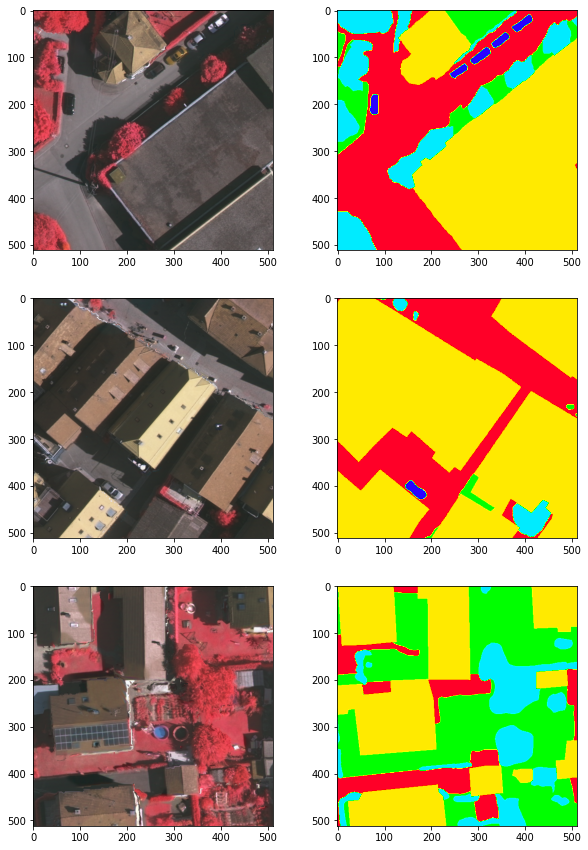

In [ ]:
### SOLUTION CODING SECTION 2.4

batch = next(iterable_train_loader)
print('This is batch number '+ str(batch[0]))
fig, axs = plt.subplots(batch_size, 2)
fig.set_size_inches(10,5*batch_size)
for i in range(batch_size):
  axs[i,0].imshow(batch[1][0].permute(0,2,3,1)[i,:,:,:])
  axs[i,1].imshow(batch[1][1][i,0,:,:],cmap=plt.get_cmap('gist_rainbow'),vmin=0,vmax=5)

## 3) Build and train the model
### 3.1) Segmentation CNN

To perform semantic segmentation, we are going to use a CNN that produces an output with the same spatial extent as the input image. So the first thing we want to do is to define the architecture. As a first model, we are going to build a model called 'hypercolumn'.

### 3.2) Building blocks of a CNN
As we have seen during the lecture, a CNN is made of three main ingredients:
1. Convolutions: in pytorch, a 2D convolution is defined as follow:
> nn.Conv2d(number_input_channels, number_output_channels, kernel_size)
2. Pooling layers: as we have seen, there are several types of pooling layers. We will use maxpooling:
> nn.MaxPool2d(kernel_size)
3. Activation function: once again, there are several activation functions. For instance, ReLU:
> nn.ReLU()

An additional building block that we will need to prepare our hypercolumn model is the upsample function:
> nn.Upsample(size_to_which_we_should_interpolate, mode='bilinear')

Once all the intermediate tensors have the same spatial size, we can concatenate them together by putting the tensors in a list or a tuple and defining along which dimension to concatenate (in our case 1, the channel dimension):
> torch.cat(list_of_tensors, dim)

The typical way of defining a network is to instantiate the building blocks in the \_\_init\_\_ function of the network, and to use them in the forward function to predict the output. So let's do that!

IMPORTANT! Keep checking the [Pytorch documentation](https://pytorch.org/docs/stable/index.html), or asking Google, if you are not sure how a module works.

In [ ]:
# In this cell we create the layers that form a minimal segmentation CNN.
# This is what needs to be done inside the CNN's __init__() method.

import torch
import torch.nn as nn

# Define three convolutional layers.
conv1 = nn.Conv2d(3, 32, 7)
conv2 = nn.Conv2d(32, 64, 5)
conv3 = nn.Conv2d(64, 128, 5)

#Pooling layer:
pool = nn.MaxPool2d(3)

#The interpolation. Note that it will upsample any input size to 512*512
interpol = nn.Upsample(size=(512,512), mode='bilinear', align_corners=True)

#And the final MLP layers. Note that we use 1*1 convolution for that.
MLP1 = nn.Conv2d((128+64+32+3), 128, 1)
MLP2 = nn.Conv2d(128, 6, 1)

In [ ]:
# And here we apply them to an image.
# This is what needs to be done inside the CNN's forward() method.

batch = next(iterable_train_loader) # We first obtain a batch from the dataloader
x = batch[1][0]
print('Original data shape: '+str(x.shape))
#Go through the feature extractors
x1 = pool(conv1(x))
x1 = x1.relu()
print('Shape after conv1+pool: '+str(x1.shape))
x2 = pool(conv2(x1))
x2 = x2.relu()
print('Shape after conv2+pool: '+str(x2.shape))
x3 = pool(conv3(x2))
x3 = x3.relu()
print('Shape after conv2+pool: '+str(x3.shape))

# Upsample feature maps and concatenate
features = torch.cat((x, interpol(x1), interpol(x2), interpol(x3)),1)
print('Shape after upsampling+concat: '+str(features.shape))
hc1 = MLP1(features).relu()
print('Shape after MLP1: '+str(hc1.shape))
output = MLP2(hc1)
print('Shape of the output: '+str(output.shape))

Original data shape: torch.Size([3, 3, 512, 512])
Shape after conv1+pool: torch.Size([3, 32, 168, 168])
Shape after conv2+pool: torch.Size([3, 64, 54, 54])
Shape after conv2+pool: torch.Size([3, 128, 16, 16])
Shape after upsampling+concat: torch.Size([3, 227, 512, 512])
Shape after MLP1: torch.Size([3, 128, 512, 512])
Shape of the output: torch.Size([3, 6, 512, 512])


To implement it in pytorch, we will define a class. This class inherits nn.Module and needs to implement two methods:
1. `__init__(self):` the method which will be called upon initialization of the model
2. `forward(self, input):` the method which will feedforward the input into the network, and needs to return the output of the network.

You can find a minimal example (an empty network) below. Fill it in with the two above sections. **Remember to add the `self.` to all the modules so that they become attached to the model.**

In [ ]:
%%script echo skipping
#### CODING SECTION 3.2
import torch
import torch.nn as nn

class Hypercolumns(nn.Module):
    def __init__(self):
        super(Hypercolumns, self).__init__()
        # Define the network modules here
        # e.g. self.f = nn.Conv2d(3,32,5,5)


    def forward(self, x):
        #Do something with x:
        #e.g. output = self.f(x)
        #return output
        return x


skipping


In [ ]:
#### SOLUTION CODING SECTION 3.2

import torch
import torch.nn as nn

class Hypercolumns(nn.Module):
    def __init__(self):
        super(Hypercolumns, self).__init__()

        #Define the convolution layers
        self.conv1 = nn.Conv2d(3, 32, 7)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        #Pooling layer:
        self.pool = nn.MaxPool2d(3)

        #The interpolation. Note that it will upsample any input size to 512*512
        self.interpol = nn.Upsample(size=(512,512), mode='bilinear', align_corners=True)

        #And the final MLP layers. Note that we use 1*1 convolution for that.
        self.MLP1 = nn.Conv2d((128+64+32), 128, 1)
        self.MLP2 = nn.Conv2d(128, 6, 1)

    def forward(self, x):
        #Go through the feature extractors
        x1 = self.pool(self.conv1(x))
        x1 = self.bn1(x1)
        x1 = x1.relu()

        x2 = self.pool(self.conv2(x1))
        x2 = self.bn2(x2)
        x2 = x2.relu()

        x3 = self.pool(self.conv3(x2))
        x3 = self.bn3(x3)
        x3 = x3.relu()


        #Construct hypercolumn
        features = torch.cat((self.interpol(x1), self.interpol(x2), self.interpol(x3)),1)

        #MLP
        hc1 = self.MLP1(features).relu()
        output = self.MLP2(hc1)

        return output

We can now check that it works by feeding a simple input (an empty image) to our network. Note that in pytorch, 2D inputs are defined as $(N, C, H, W)$ where $N$ is the number of samples (in our case 1), $C$ is the number of channels (in our case 3) and $H$ and $W$ are the height and width of the sample respectively.

In [ ]:
network = Hypercolumns()
batch = next(iterable_train_loader)
output = network(batch[1][0])
print(output.shape)

torch.Size([3, 6, 512, 512])


We obtained an output of the same spatial input size, but with 6 channels (one for each class), which is what we wanted!

Remember to comment out or remove any print statements on the forward method in order to prevent a flood of prints when training the model.

### 3.4) Training the model

Now that we have a model and our training data, we are going to be able to actually train the model.

The most common way to train such a model is to proceed by *epochs*: during one epoch, we go through the training set once (feedforwarding the batches and backpropagate the gradients). Then we will compute the loss on the validation set to check that we are not overfitting or underfitting.

So the first thing we want to do is to define the loss function. Once again, pytorch implements several of them. The one that we will use is a classification loss (after all, we are trying to assign a class to each of the pixels) and is called the cross-entropy. It is defined as follow:

$l(\mathbf{y_i}, \hat{y}_i) = -  \log \left(\frac{exp(y_{i,\hat{y}_i})}{\sum_c exp(y_{i,c})}\right)$, where $y_{i,c}$ is the score of class $c$ at pixel $i$. To use it in pytorch, we just instantiate the following:

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()

Then, we want to use an optimizer. In pytorch, you have to instantiate an object which will keep track of the current state and of the parameters to optimize. The most simple optimization algorithm that you can use is the stochastic gradient descent (SGD):

In [ ]:
optimizer = torch.optim.SGD(network.parameters(), lr=0.1)

We now have all the ingredients required to do the training!

So let's build our training loop and run it!

**Careful:**
* you should enable GPU in your collab at this point. To do so go to runtime -> Change runtime type -> Hardware accelerator and select "GPU";
* the default epoch number (3) should run in around 5min (on GPU).

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


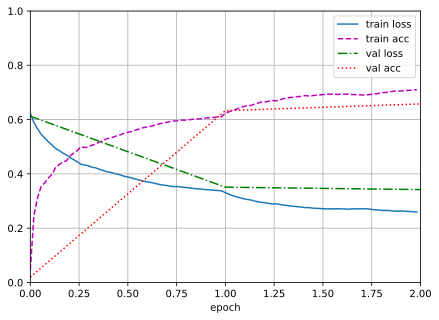

In [ ]:
!pip install d2l==0.14.2 -q
from d2l import torch as d2l
from collections import deque
from statistics import mean


def evaluate(net, validate_loader, loss_function):
  #You need to set the network to eval mode when using batch normalization (to
  #be consistent across evaluation samples, we use mean and stddev computed
  #during training when doing inference, as opposed to ones computed on the
  #batch) or dropout (you want to use all the parameters during inference).
  net.eval()  # Set the model to evaluation mode
  device = next(iter(net.parameters())).device
  metric = d2l.Accumulator(4)
  #This line reduces the memory by not tracking the gradients. Also to be used
  #during inference.
  with torch.no_grad():
    for i, (inputs, GTs) in enumerate(validate_loader):
      #Send inputs and GTs them to the computation device (i.e. GPU). The GTs tensor
      #has to be converted to nn.LongTensor type (a type of integer) and turned into
      #a 3D tensor by removing dimension 1 with the squeeze() function.
      inputs = inputs.to(device)
      GTs = GTs.type(torch.LongTensor).to(device).squeeze(1)
      pred = network(inputs)
      loss = loss_function(pred, GTs)
      overall_accuracy = (pred.max(1)[1]==GTs).float().mean()
      metric.add(loss, GTs.shape[0], overall_accuracy, 1)
  return metric


number_epochs = 2

animator = d2l.Animator(xlabel='epoch', xlim=[0, number_epochs], ylim=[0, 1],
                        legend=['train loss', 'train acc', 'val loss', 'val acc'],
                        fmts=('-', 'm--', 'g-.', 'r:'),
                        figsize=(7, 5))

network = Hypercolumns()
network.to(device)
optimizer = torch.optim.SGD(network.parameters(), lr=0.1)
#Training metrics are computed as a running average of the last x samples
loss_train = deque(maxlen=len(train_loader))
accuracy_train = deque(maxlen=len(train_loader))

for epoch in range(number_epochs):
  #Validation phase:
  metric_val = evaluate(network, validate_loader, loss_function)
  animator.add(epoch,(None, None, metric_val[0]/metric_val[1], metric_val[2]/metric_val[3]))

  #Training phase:
  network.train() #indicate to the network that we enter training mode
  for i, (inputs, GTs) in enumerate(train_loader):
    inputs = inputs.to(device)
    GTs = GTs.type(torch.LongTensor).to(device).squeeze(1)
    #We set the gradients of the model to 0.
    optimizer.zero_grad()
    pred = network(inputs)
    loss = loss_function(pred, GTs)
    overall_accuracy = (pred.max(1)[1]==GTs).float().mean()
    #We accumulate the gradients...
    loss.backward()
    #...and we update the parameters according to the gradients.
    optimizer.step()
    loss_train.append(loss.item()/GTs.shape[0])
    accuracy_train.append(overall_accuracy.item())
    animator.add(epoch+i/len(train_loader),
                      (mean(loss_train), mean(accuracy_train), None, None))


  #After each training epoch, reduce the learning rate by a factor of 0.25
  optimizer.param_groups[0]['lr'] *= 0.25

metric_val = evaluate(network, validate_loader, loss_function)
animator.add(epoch+1,(None, None, metric_val[0]/metric_val[1], metric_val[2]/metric_val[3]))


#Optional, if you want to save your model (you will need to use a folder where you have writing rights):
#torch.save(network.state_dict(), os.path.join(base_folder, 'WeightsVaihingen/', 'Hypercolumns_' + str(number_epochs) + "epochs.pth")
#torch.save(network.state_dict(), os.path.join(base_folder, 'WeightsVaihingen/', 'Hypercolumns_augm_weigths_' + str(number_epochs) + 'epochs.pth'))


You will probably not be very satified with these first results. One way of improving convergence in such a short training schedule is to use Batch Normalization. Simply uncomment the three lines in the provided solution for coding section 3.2 that refer to batch norm (e.g. `x1 = self.bn1(x1)`). This should already improve the results. In addition, you can also try with different training schedules, like starting with a lower learning rate but using more epochs and also making learning rate decay less aggressive (like 0.8 instead of 0.25). You can also experiment with different optimizers, like Adam, improving the architecture, like using U-Net, or increasing the weight of the minority classes that tend to be ignored, such as cars.

This improvement should also be apparent when looking at the prediction maps. Use the code below for that.

This is batch number 3


Text(0.5, 1.0, 'Prediction')

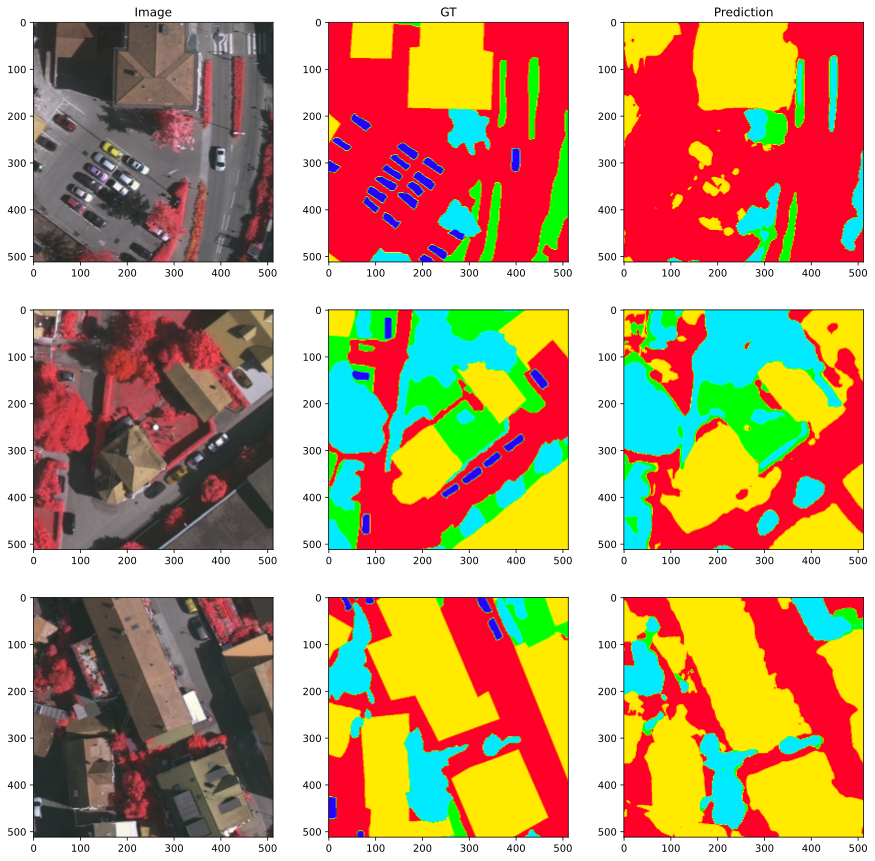

In [ ]:
batch = next(iterable_train_loader)
pred = network(batch[1][0].to(device))
print('This is batch number '+ str(batch[0]))
fig, axs = plt.subplots(batch_size, 3)
fig.set_size_inches(15,5*batch_size)
for i in range(batch_size):
  axs[i,0].imshow(batch[1][0].permute(0,2,3,1)[i,:,:,:])
  axs[i,1].imshow(batch[1][1][i,0,:,:],cmap=plt.get_cmap('gist_rainbow'),vmin=0,vmax=5)
  axs[i,2].imshow(pred[i,:,:,:].max(0)[1].cpu(),cmap=plt.get_cmap('gist_rainbow'),vmin=0,vmax=5)
axs[0,0].set_title('Image')
axs[0,1].set_title('GT')
axs[0,2].set_title('Prediction')